## Tutorial para la realización de ajustes lineales

En este archivo muestro como:

- Cargar un conjunto de datos y hacer un Pre- procesamiento
- Calcular los errores en base a información del instrumental utilizado
- Hacer un ajuste lineal ponderado por los errores de medición
- Calcular los intervalos de confinza
- Calcular las bandas de confianza

Arranco importando la librerías que voy a utilizar:

In [2]:
import pandas as pd                             # manejo de datos
import numpy as np                              # operación con arrays
import matplotlib.pyplot as plt                 # para graficar

### Carga y preprocesamiento de datos

En primer lugar cargamos los datos que adquirimos en nuestro experimento. Vamos a utilizar la libreria pandas:

In [3]:
df = pd.read_csv("Datos/data_LeyDeOhm.csv")                 # cargamos los datos a un objeto DataFrame 

print (df.shape)                                            # imprimimos las dimensiones de la matrix de datos: (filas,columnas)

df.head()                                                   # inspeccionamos los primeros 10 datos

(20, 2)


,corriente [mA],tension [V]
0,10.491378,1.045658
1,8.181423,0.813871
2,9.731880,1.005271
3,7.679995,0.773010
4,7.443637,0.728722


Al adquirir solemos tomar los datos de forma desordenada, una buena costumbre es ordenarlos, aplicamos la rutina *.sort_values()* sobre el objeto *df* de pandas y ordenamos por valor de corriente:

In [4]:
df_ord = df.sort_values(by='corriente [mA]')

Guardamos los datos en dos arrays de *numpy* para operar mas facilmente:

In [5]:
I = df_ord["corriente [mA]"].to_numpy()
V = df_ord["tension [V]"].to_numpy()

### Calculo de errores

En este ejemplo, los valores de tensión y corriente fueron medidos con dos multimetros *modelo UT51-55* de *3 1/2 dígitos*.

#### **Errores en el voltaje**:

$$
\Delta V = \frac{\% error}{100} \times V_{Medido} + n\times LSB
$$

Se midió en la escala de $2 V$.

El porcentaje de error es de $0.5\%$ (para todas las escalas).

En la escala de $2 V$, podemos ir del $0.000$ al $1.999$, entonces el LSB (bit menos significativo) es $0.001$. El valor de $n=1$ para todas las escalas.

Con esta información, calculamos el error en la medición de voltaje:

In [6]:
Verr = (0.5/100)*V + 1*0.001

#### **Errores en la corriente**:

$$
\Delta I = \frac{\% error}{100} \times I_{Medido} + n\times LSB
$$

Se midió en la escala de $20mA$.

Para esa escala el porcentaje de error es $0.8\%$.

En la escala de $20 mA$, podemos ir desde $00.00$ hasta $19.99$, entonces el LSB es $0.01$. Para esta escala $n=1$.

El error en la medición de la corriente será entonces:

In [7]:
Ierr = (0.8/100)*I + 1*0.01

### Primera inspección visual de los datos

Vamos a hacer un primer gráfico con los errores para visualizar los resultados obtenidos.

La corriente esta en $mA$, una buena costumbre (siempre que se pueda) es analizar los datos en unidades estandar, en este caso *Volt* - *Ampere*. Para esto divido por $1000$ en los arrays que contienen información de la corriente, $I$ y $Ierr$:

In [8]:
I=I/1000
Ierr = Ierr/1000

Ahora graficamos:

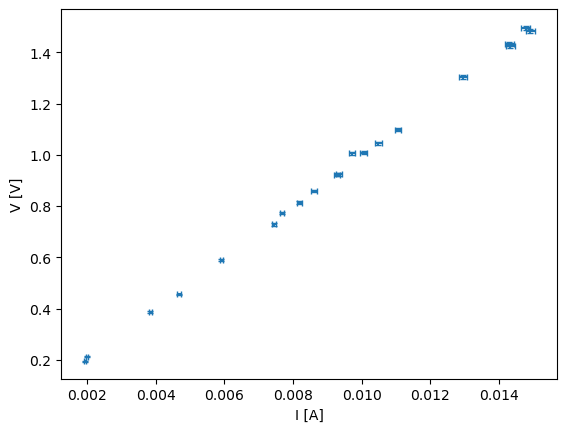

In [9]:
fig,ax = plt.subplots()

ax.errorbar( x=I,y=V, xerr=Ierr, yerr=Verr, fmt='none', capsize=2)      # Formato fmt='[tipo de punto][color]': fmt='none' sin formato, fmt='.r' puntos rojos

ax.set_xlabel("I [A]")
ax.set_ylabel("V [V]")

plt.show()

## Ajuste Lineal



Hay muchas opciones de librerías en python para hacer un ajuste lineal, probablemente una de las más completas es [*statsmodels*](https://www.statsmodels.org/stable/index.html). Emepezamos importando:

In [10]:
import statsmodels.api as sm

Queremos hacer un ajuste lineal que tenga en cuenta los errores. 

Si sabemos que los errores vienen de una distribución normal, conviene definir los pesos como $w = \frac{1}{yerr^2}$, esto le otorga más pesos a los errores chicos y asegura la minimización de $\chi^2$.

Si los errores son más bien estimaciones, o los datos son pocos, conviene definir los pesos como $w = \frac{1}{yerr}$ esto le otorga menos peso a los errores chicos.

En este caso, como son pocos datos y no puedo determinar la distribución de los errores voy a utilizar la segunda opción:

In [11]:
w= 1/Verr           # definición de los pesos

Vamos a utilizar la clase *sm.WLS()* que efectua un  [*Weighted Least Squares*](https://en.wikipedia.org/wiki/Weighted_least_squares). 

Para que la rutina calcule el intercepto (ordenada al origen) en la regresión, es necesario agregar una constante a la variable dependiente. Esto es simplemente un requerimiento de la rutina, que trabaja con ese formato de datos. Para hacerlo ejecutamos:

In [12]:
X = sm.add_constant(I)  # Convierte I en matriz [1, I]

Ahora, ya con todos los elementos, podemos definir el modelo lineal:

In [13]:
model = sm.WLS(V, X, weights=w)  # WLS = Weighted Least Squares, con pesos w=1/yerr

Con el modelo definido, solo queda hacer el ajuste:

In [14]:
results = model.fit()

Como ven es bastante simple. El objeto *results* contiene todos los resultados del ajuste. A partir de distintas rutinas podremos ir accediendo a cada uno de los resultados.

### Análisis de los parámetros del ajuste

Los parámetros de la regresión son:

In [ ]:
ordenada , pendiente = results.params               # contiene los parámetros

err_ordenada, err_pendiente = results.bse           # contiene los errores estandar (SE)

print ("Parámetros de la regresión V ~ R I + V0:")
print ("Pendiente :  R = %.2f ± %.2f" % ( pendiente, err_pendiente ) )
print ("Intercepto: V0 = %.3f ± %.3f" % ( ordenada,  err_ordenada )  )

Parámetros de la regresión V ~ R I + V0:
Pendiente :  R = 99.69 ± 0.58
Intercepto: V0 = 0.003 ± 0.005


Es importante notar que los **errores estándar (SE)**  de los coeficientes estimados representan la dispersión de la estimación alrededor del valor verdadero del parámetro. A partir de estos podemos construir intervalos de confianza para definir un rango estimado para cada coeficiente, esto proporciona una mejor interpretación de la incertidumbre.

### Intervalos de confianza (CI)

Se definen como:

$$
CI = \hat{\beta} \pm z \times SE
$$

Donde:
- $\hat{\beta}$ es el valor que obtenemos del parámetro en el ajuste
- SE es el error estandar, el error que tiene el parámetro que sale del ajuste
- z es el valor crítico de la distribución normal y esta relacionado con el nivel de confianza así:

  - $z \approx 1.96$ $\Rightarrow$ 95% de confianza ($\alpha = 0.05$) 
  - $z \approx 1.28$ $\Rightarrow$ 80% de confianza ($\alpha = 0.20$): 
  - $z \approx 1.00$ $\Rightarrow$ 68% de confianza, cercano a 1 error estándar ($\alpha = 0.32$): 


Para obtener los intervalos de confianza desde el objeto *results* utilizamos la rutina *results.conf_int(alpha)* y pide que le demos un valor de $\alpha$ de acuerdo al tamaño del intervalo que querramos, por ejemplo para obtener los intervalos del $95\%$ ejecutamos:

In [ ]:
CI = results.conf_int(alpha=0.05)

Esto nos da una matriz $2x2$ donde la primer fila tiene los intervalos de confianza asociados a la ordenada y la segunda fila los asociados a la pendiente, para separarlos:

In [22]:
ci_ordenada = CI[0,:]       # tomo todas las columnas (2) de la primer ila
ci_pediente = CI[1,:]

print ("El intervalo de cofianza del $95\%$ de los parametros es:")
print ("Pendiente : R  = ( %.2f, %.2f) " % (ci_pediente[0], ci_pediente[1]) )
print ("Intercepto: V0 = ( %.3f, %.3f) " % (ci_ordenada[0], ci_ordenada[1]) )

El intervalo de cofianza del $95\%$ de los parametros es:
Pendiente : R  = ( 98.47, 100.91) 
Intercepto: V0 = ( -0.007, 0.013) 


Note que el intervalo donde se encuentra el valor real del intercepto encierra al valor $0$, esto es consistente con la ecuación teórica de la **ley de Ohm** que no contempla la existencia de un $V0$. 

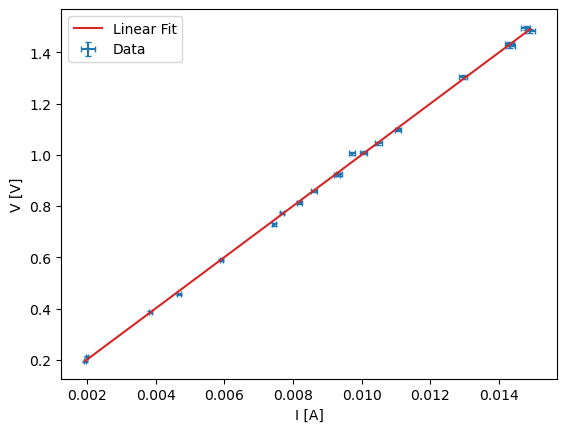

In [17]:
a, b = results.params
fl= lambda u: a+b*u


fig,ax = plt.subplots()

ax.errorbar( x=I,y=V, xerr=Ierr, yerr=Verr, fmt='none', capsize=2, label='Data')

ax.plot( I, fl(I), c='C3' , label='Linear Fit')

ax.set_xlabel("I [A]")
ax.set_ylabel("V [V]")

plt.legend()
plt.show()